### The effect of concept drift on bandit algorithms
Bandit algorithms commonly assume a stationary environment. However, concept drift can affect the environment when these algorithms are put into practise.

In this notebook we show how various types of concept drift can be simulated using OBP.

The OBP Drift implementation works by changing the coefficients that define $f(r|x)$. The coefficients and therefor drift can be controlled by the following parameters:
* Seasonality - When true, the drift will happen between two distinct sets of coefficients. When false, each instances of drift will generate a new set of coefficients
* Base coefficient - Which defines the contribution of a base coefficient to the drifting environment. Eg. setting the base coefficient to .3 will combine the coefficients by add 30% of a static coefficient set and 70% of the combination of drifting coefficients. This allows the model to have some base coefficients to learn.
* Transition period - The time in rounds it takes to transition between two sets of coefficients.
* Transition type - The type of transition being either linear or weighted_sampled. These correspond to the linear and gradual drifts as described by *Cavenaghi, Emanuele, et al.*[1] respectively..


The parameters in OBP can be used to simulate any combination of methods described by *Cavenaghi, Emanuele, et al.*[1] and more. It is also possible to combine drift with reward delay in order to create even more realistic environments. However, in this notebook we restrict ourselves to one example of seasonal and one example of non-seasonal drift both without any reward delay.


[1] [Cavenaghi, Emanuele, et al. "Non stationary multi-armed bandit: Empirical evaluation of a new concept drift-aware algorithm." Entropy 23.3 (2021): 380.](https://pdfs.semanticscholar.org/dc0d/c6b836205f6d9ecfcb479e17036efe666ea9.pdf)

In [1]:
import copy
from functools import partial

import numpy as np
import seaborn as sns
import pandas as pd

from obp.policy.offline import IPWLearner
from obp.dataset import logistic_sparse_reward_function
from obp.policy import Random, EpsilonGreedy, BernoulliTS, LinTS, LinUCB
from obp.simulator.coefficient_drifter import CoefficientDrifter
from obp.simulator.simulator import BanditEnvironmentSimulator, BanditPolicySimulator

#### Seasonal concept drift with small linear transition period.
In this section we demonstrate a seasonal drift with a short linear transition period.

In [2]:
experiment_round_size = np.arange(start=1000, stop=50001, step=1000).tolist()
drift_interval = 5000
transition_period = 500
seasonal = True
n_runs_per_round_size = 1000
max_scale = 1000.0
min_scale = 900.0
n_actions = 3
dim_context = 5
reward_func = partial(logistic_sparse_reward_function, z_score=False)

drift_bandit_policies = [
    (EpsilonGreedy, {"n_actions": n_actions, "epsilon": 0.1, "random_state": 12345}),
    (BernoulliTS, {"n_actions": n_actions, "random_state": 12345}),
    (LinTS, {"dim": dim_context, "n_actions": n_actions, "random_state": 12345}),
    (LinUCB, {"dim": dim_context, "n_actions": n_actions, "random_state": 12345}),
]

no_drift_bandit_policies = [
    (Random, {"n_actions": n_actions, "epsilon": 1.0, "random_state": 12345}),
    (BernoulliTS, {"n_actions": n_actions, "random_state": 12345}),
]

dummy_policies = [policy_class(**args) for policy_class, args in drift_bandit_policies]
train_rewards = {policy.policy_name + f" drift": [] for policy in dummy_policies}
dummy_policies = [policy_class(**args) for policy_class, args in no_drift_bandit_policies]
train_rewards.update({policy.policy_name + f" no drift": [] for policy in dummy_policies})
eval_rewards = {**copy.deepcopy(train_rewards), **{IPWLearner.__name__: []}}
train_rewards["n_rounds"] = []
eval_rewards["n_rounds"] = []


In [3]:
%%time

for experiment in range(n_runs_per_round_size):
    drifter = CoefficientDrifter(
        drift_interval=drift_interval,
        transition_period=transition_period,
        transition_type="linear",  # linear or weighted_sampled
        seasonal=seasonal,
        base_coefficient_weight=.3,
        random_state=1234
    )

    env = BanditEnvironmentSimulator(
        n_actions=n_actions,
        dim_context=dim_context,
        reward_type="binary",
        reward_function=reward_func,
        delay_function=None,
        coef_function=drifter.get_coefficients,
        random_state=12345 + experiment,
    )

    sample_n_rounds = max(experiment_round_size)
    training_bandit_batch = env.next_bandit_round_batch(n_rounds=sample_n_rounds)

    for policy_class, args in drift_bandit_policies:
        policy = policy_class(**args)
        training_simulator = BanditPolicySimulator(policy=policy)
        training_simulator.steps(batch_bandit_rounds=training_bandit_batch)

        for n_rounds in experiment_round_size:
            train_rewards[policy.policy_name + " drift"].append(np.sum(training_simulator.obtained_rewards[:n_rounds]))

    for n_rounds in experiment_round_size:
        train_rewards["n_rounds"].append(n_rounds)

100%|██████████| 50000/50000 [00:01<00:00, 26503.31it/s]


CPU times: user 9.69 s, sys: 683 ms, total: 10.4 s
Wall time: 9.88 s


In [74]:
%%time

for experiment in range(n_runs_per_round_size):
    drifter = CoefficientDrifter(
        drift_interval=drift_interval,
        transition_period=transition_period,
        transition_type="linear",  # linear or weighted_sampled
        seasonal=seasonal,
        base_coefficient_weight=1.0,
        random_state=1234
    )


    env = BanditEnvironmentSimulator(
        n_actions=n_actions,
        dim_context=dim_context,
        reward_type="binary",
        reward_function=reward_func,
        delay_function=None,
        coef_function=drifter.get_coefficients,
        random_state=12345 + experiment,
    )

    sample_n_rounds = max(experiment_round_size)
    training_bandit_batch = env.obtain_batch_bandit_feedback(n_rounds=sample_n_rounds)

    for policy_class, args in drift_bandit_policies:
        policy = policy_class(**args)
        training_simulator = BanditPolicySimulator(policy=policy)
        training_simulator.steps(batch_bandit_rounds=training_bandit_batch)

        for n_rounds in experiment_round_size:
            train_rewards[policy.policy_name + " no drift"].append(np.sum(training_simulator.obtained_rewards[:n_rounds]))


100%|██████████| 50000/50000 [00:00<00:00, 78263.68it/s]

CPU times: user 32min 11s, sys: 21min 41s, total: 53min 52s
Wall time: 24min 31s


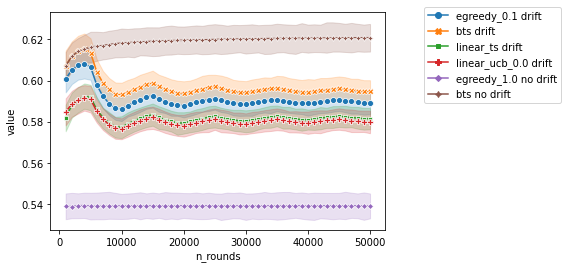

In [75]:
def plot_average_reward_per_n_rounds(rewards):
    rewards_pd = pd.DataFrame(rewards)
    rewards_pd = pd.melt(rewards_pd, ['n_rounds'])
    rewards_pd["value"] = rewards_pd["value"] / rewards_pd["n_rounds"]

    plot = sns.lineplot(data=rewards_pd, x="n_rounds", y="value", style="variable", hue="variable", markers=True, dashes=False)
    plot.legend(bbox_to_anchor=(1.1, 1.05))

# 1000 runs, only with drift, all models.
# 25,000 interval, 50,000 steps. transition period of 5000. Non-seasonal.
# base-coef is 0.3
plot_average_reward_per_n_rounds(train_rewards)

#### One-time drift with short linear transition period.
In this section we demonstrate a drift period with a short linear transition period half-way through its horizon.

In [ ]:
experiment_round_size = np.arange(start=1000, stop=50001, step=1000).tolist()
drift_interval = 25000
transition_period = 5000
seasonal = True
n_runs_per_round_size = 1000
max_scale = 1000.0
min_scale = 900.0
n_actions = 3
dim_context = 5
reward_func = partial(logistic_sparse_reward_function, z_score=False)

drift_bandit_policies = [
    (EpsilonGreedy, {"n_actions": n_actions, "epsilon": 0.1, "random_state": 12345}),
    (BernoulliTS, {"n_actions": n_actions, "random_state": 12345}),
    (LinTS, {"dim": dim_context, "n_actions": n_actions, "random_state": 12345}),
    (LinUCB, {"dim": dim_context, "n_actions": n_actions, "random_state": 12345}),
]

no_drift_bandit_policies = [
    (Random, {"n_actions": n_actions, "epsilon": 1.0, "random_state": 12345}),
    (BernoulliTS, {"n_actions": n_actions, "random_state": 12345}),
]

dummy_policies = [policy_class(**args) for policy_class, args in drift_bandit_policies]
train_rewards = {policy.policy_name + f" drift": [] for policy in dummy_policies}
dummy_policies = [policy_class(**args) for policy_class, args in no_drift_bandit_policies]
train_rewards.update({policy.policy_name + f" no drift": [] for policy in dummy_policies})
eval_rewards = {**copy.deepcopy(train_rewards), **{IPWLearner.__name__: []}}
train_rewards["n_rounds"] = []
eval_rewards["n_rounds"] = []

In [ ]:
%%time

for experiment in range(n_runs_per_round_size):
    drifter = CoefficientDrifter(
        drift_interval=drift_interval,
        transition_period=transition_period,
        transition_type="linear",
        seasonal=seasonal,
        base_coefficient_weight=.3,
        random_state=1234
    )

    env = BanditEnvironmentSimulator(
        n_actions=n_actions,
        dim_context=dim_context,
        reward_type="binary",
        reward_function=reward_func,
        delay_function=None,
        coef_function=drifter.get_coefficients,
        random_state=12345 + experiment,
    )

    sample_n_rounds = max(experiment_round_size)
    training_bandit_batch = env.obtain_batch_bandit_feedback(n_rounds=sample_n_rounds)

    for policy_class, args in drift_bandit_policies:
        policy = policy_class(**args)
        training_simulator = BanditPolicySimulator(policy=policy)
        training_simulator.steps(batch_bandit_rounds=training_bandit_batch)

        for n_rounds in experiment_round_size:
            train_rewards[policy.policy_name + " drift"].append(np.sum(training_simulator.obtained_rewards[:n_rounds]))


    for n_rounds in experiment_round_size:
        train_rewards["n_rounds"].append(n_rounds)

In [ ]:
%%time
for experiment in range(n_runs_per_round_size):
    drifter = CoefficientDrifter(
        drift_interval=drift_interval,
        transition_period=transition_period,
        transition_type="linear",
        seasonal=seasonal,
        base_coefficient_weight=.3,
        random_state=1234
    )

    env = BanditEnvironmentSimulator(
        n_actions=n_actions,
        dim_context=dim_context,
        reward_type="binary",
        reward_function=reward_func,
        delay_function=None,
        coef_function=drifter.get_coefficients,
        random_state=12345 + experiment,
    )

    sample_n_rounds = max(experiment_round_size)
    training_bandit_batch = env.obtain_batch_bandit_feedback(n_rounds=sample_n_rounds)

    for policy_class, args in drift_bandit_policies:
        policy = policy_class(**args)
        training_simulator = BanditPolicySimulator(policy=policy)
        training_simulator.steps(batch_bandit_rounds=training_bandit_batch)

        for n_rounds in experiment_round_size:
            train_rewards[policy.policy_name + " drift"].append(np.sum(training_simulator.obtained_rewards[:n_rounds]))


    for n_rounds in experiment_round_size:
        train_rewards["n_rounds"].append(n_rounds)

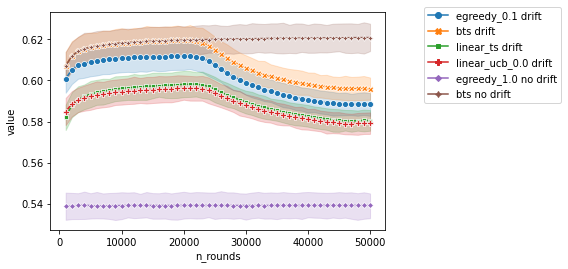

In [71]:
def plot_average_reward_per_n_rounds(rewards):
    rewards_pd = pd.DataFrame(rewards)
    rewards_pd = pd.melt(rewards_pd, ['n_rounds'])
    rewards_pd["value"] = rewards_pd["value"] / rewards_pd["n_rounds"]

    plot = sns.lineplot(data=rewards_pd, x="n_rounds", y="value", style="variable", hue="variable", markers=True, dashes=False)
    plot.legend(bbox_to_anchor=(1.1, 1.05))

# 1000 runs, all models with drift, bts and random without drift.
# 25,000 interval, 50,000 steps. transition period of 5000. Non-seasonal.
# base-coef is 0.3
# All models are heavily hit by the drift event and do not recover within the same time period as the model was able to learn before.
# However, all models still perform signicantly better than random due to the base coef being the same.
plot_average_reward_per_n_rounds(train_rewards)